In [2]:
pip install pydub

In [3]:
import torch
import numpy as np
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
%matplotlib inline
from pydub import AudioSegment

In [4]:
def convert_mp3_to_wav(mp3_path, wav_path):
    """Convert MP3 to WAV using pydub."""
    audio = AudioSegment.from_mp3(mp3_path)
    audio.export(wav_path, format="wav")

In [5]:
def load_audio(file_path):
    """Load audio file using scipy."""
    sample_rate, audio_data = read(file_path)
    if audio_data.dtype != np.float32:
        audio_data = audio_data.astype(np.float32) / np.iinfo(audio_data.dtype).max
    return torch.from_numpy(audio_data), sample_rate

In [6]:
def generate_spectrogram(audio, sample_rate, n_fft=2048, hop_length=512):
    """Generate spectrogram using PyTorch STFT."""
    # Convert stereo to mono if needed
    if audio.dim() > 1:
        audio = audio.mean(dim=1)

    # Compute STFT
    stft = torch.stft(audio, n_fft=n_fft, hop_length=hop_length, window=torch.hann_window(n_fft), return_complex=True)

    # Compute magnitude spectrogram
    spectrogram = torch.abs(stft)

    # Convert to dB scale
    spectrogram = 20 * torch.log10(spectrogram + 1e-8)  # Add small epsilon to avoid log(0)

    return spectrogram.numpy()

In [7]:
def plot_spectrogram(spectrogram, sample_rate, hop_length, genre, cmap):
    """Plot spectrogram using Matplotlib with different colormap based on genre."""
    # Time axis
    time = np.arange(spectrogram.shape[1]) * hop_length / sample_rate

    # Frequency axis (limit the frequency to 20 kHz)
    max_freq = min(sample_rate // 2, 20000)  # Limit frequency to 20 kHz
    n_freq_bins = spectrogram.shape[0]

    # Create frequency bins and limit the spectrogram
    freq = np.linspace(0, max_freq, n_freq_bins)
    spectrogram = spectrogram[:n_freq_bins, :]  # Clip to desired frequency range

    # Plot spectrogram
    plt.figure(figsize=(10, 6))
    plt.imshow(spectrogram, aspect='auto', origin='lower', extent=[time[0], time[-1], freq[0], freq[-1]], cmap=cmap)
    plt.colorbar(label='Magnitude (dB)')
    plt.title(f'Spectrogram ({genre})')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.yscale('log')  # Log scale for frequency
    plt.ylim([20, max_freq])  # Limit y-axis to avoid empty space at the top
    plt.show()  # Display the plot


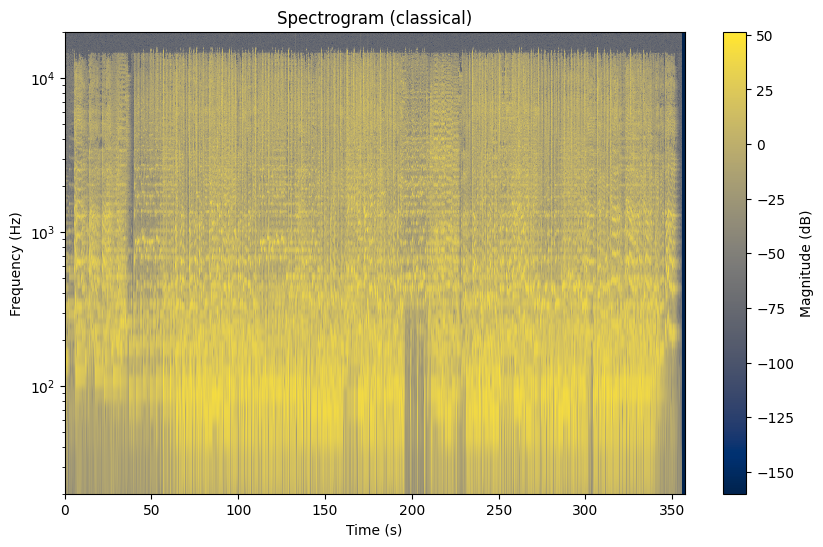

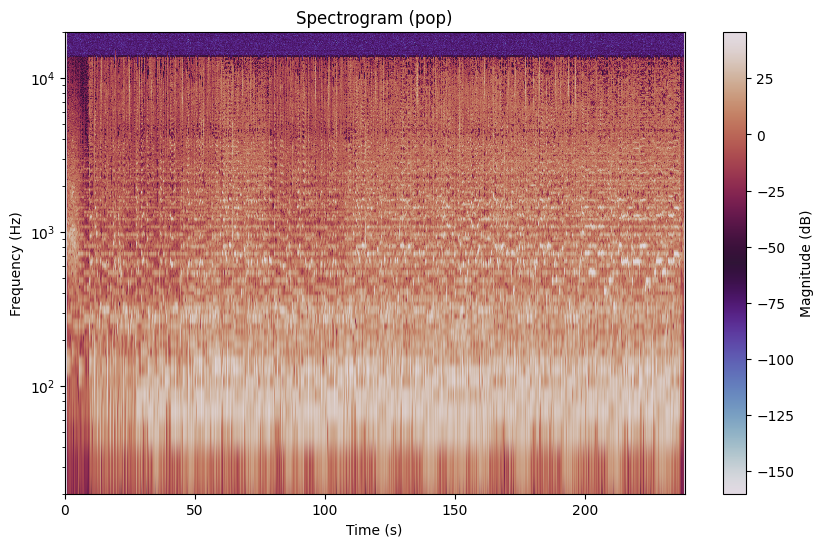

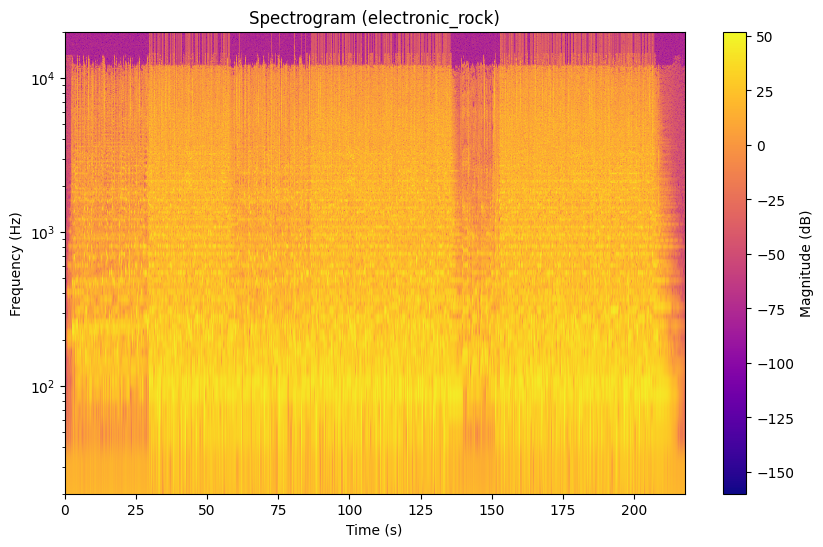

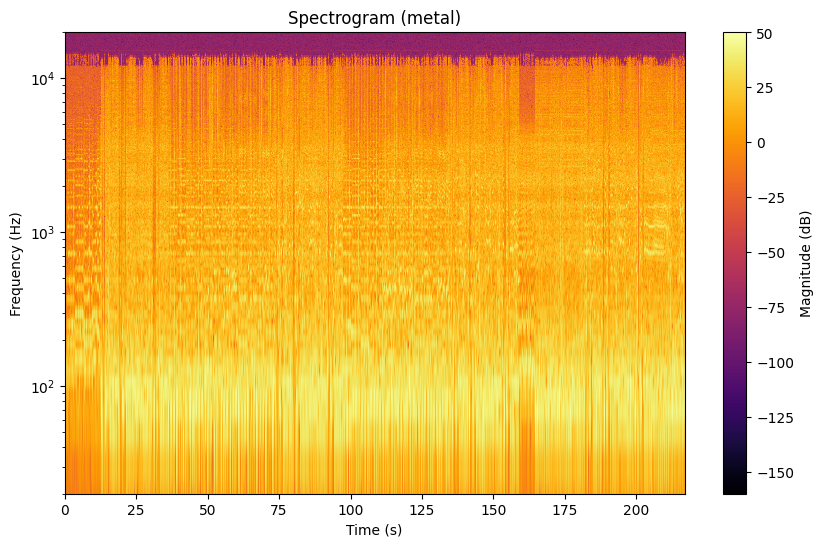

In [9]:
# List of MP3 files and their genres
songs = {
    "classical": "/content/09 Aaoge Jab Tum.mp3",
    "pop": "/content/Adele - Set Fire To The Rain (Live at The Royal Albert Hall).mp3",
    "electronic_rock": "/content/Astronaut.mp3",
    "metal": "/content/system of a down - toxicity.mp3"
}

# Colormaps for each genre
colormaps = {
    "classical": "cividis",
    "pop": "twilight",
    "electronic_rock": "plasma",
    "metal": "inferno"
}

# Process each song
for genre, mp3_path in songs.items():
    # Convert MP3 to WAV
    wav_path = f"/content/{genre}_temp.wav"
    convert_mp3_to_wav(mp3_path, wav_path)

    # Load audio
    audio, sample_rate = load_audio(wav_path)

    # Generate spectrogram
    spectrogram = generate_spectrogram(audio, sample_rate)

    # Plot spectrogram with the specified colormap
    plot_spectrogram(spectrogram, sample_rate, hop_length=512, genre=genre, cmap=colormaps[genre])